In [67]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from PIL import Image


In [73]:

base_dir = os.getcwd()  # Gets current directory where notebook is running
train_dir = os.path.join(base_dir, 'DevanagariHandwrittenDigitDataset', 'Train')
test_dir = os.path.join(base_dir, 'DevanagariHandwrittenDigitDataset', 'Test')

print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

# Verify the folders exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Train directory not found at {train_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found at {test_dir}")

Train directory: C:\Users\user\Desktop\AI ML\DevanagariHandwrittenDigitDataset\Train
Test directory: C:\Users\user\Desktop\AI ML\DevanagariHandwrittenDigitDataset\Test


In [75]:
# Image loading function with error handling
def load_devanagari_data(folder, img_size=(28, 28)):
    images = []
    labels = []
    class_folders = sorted([f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))])
    
    for label, class_folder in enumerate(class_folders):
        class_path = os.path.join(folder, class_folder)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_files:
            print(f"Warning: No images found in {class_path}")
            continue
            
        for image_file in image_files:
            try:
                img = Image.open(os.path.join(class_path, image_file)).convert('L').resize(img_size)
                img_array = np.array(img) / 255.0  # Normalize
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {image_file}: {str(e)}")
    
    return np.array(images), np.array(labels)

In [25]:
# Load datasets
print("Loading training data...")
X_train, y_train = load_devanagari_data(train_dir)
print("\nLoading test data...")
X_test, y_test = load_devanagari_data(test_dir)

Loading training data...

Loading test data...


In [77]:
# Data preprocessing
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (n_samples, 784)
X_test = X_test.reshape(X_test.shape[0], -1)



In [79]:
# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)


In [81]:
# Dataset info
print("\nDataset shapes:")
print(f"Training data: {X_train.shape}, Labels: {y_train_cat.shape}")
print(f"Test data: {X_test.shape}, Labels: {y_test_cat.shape}")


Dataset shapes:
Training data: (17000, 784), Labels: (17000, 10)
Test data: (3000, 784), Labels: (3000, 10)


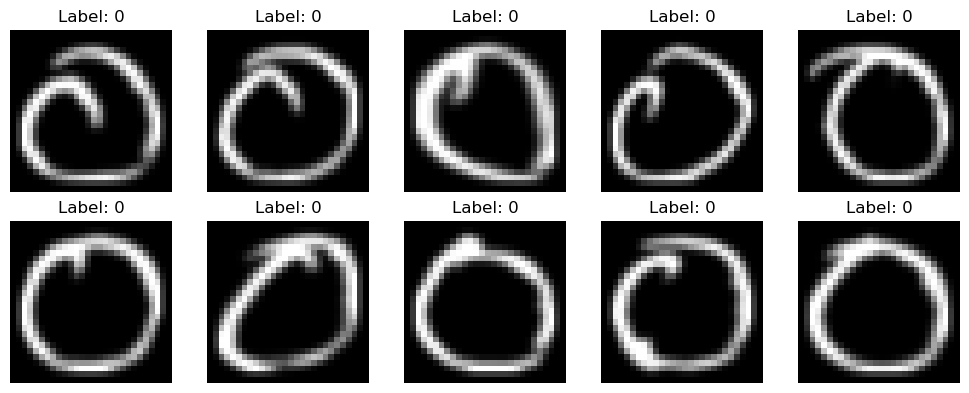

In [83]:
# Visualize samples
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [85]:
model = Sequential([
    Dense(64, activation='sigmoid', input_shape=(784,)),
    Dense(128, activation='sigmoid'),
    Dense(256, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model.summary()

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
#  Task 3: Compile the Model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [89]:
# Task 4: Train the Model 

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Improved callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                   save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=20, 
                 restore_best_weights=True, min_delta=0.001),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                     patience=5, min_lr=1e-6)
]

# Train with more epochs and adjusted batch size
history = model.fit(
    X_train, y_train_cat,
    batch_size=64,  # Reduced from 128 for better gradient updates
    epochs=100,      # Increased from 20
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/100
205/213 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3745 - loss: 1.7014

213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3839 - loss: 1.6789 - val_accuracy: 0.0000e+00 - val_loss: 8.5898 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8897 - loss: 0.3602 - val_accuracy: 0.0000e+00 - val_loss: 9.7633 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9395 - loss: 0.2010 - val_accuracy: 0.0000e+00 - val_loss: 10.2989 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9570 - loss: 0.1415 - val_accuracy: 0.0000e+00 - val_loss: 10.6400 - learning_rate: 0.0010
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9685 - loss: 0.1062 - val_accuracy: 0.0000e+00 - val_loss: 10.9410 - learning_rate: 0.0010
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9772 - loss: 0.0828 - val_accuracy: 0.0000e+00 - val_loss: 11.2066 - learning_rate: 0.0010
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0

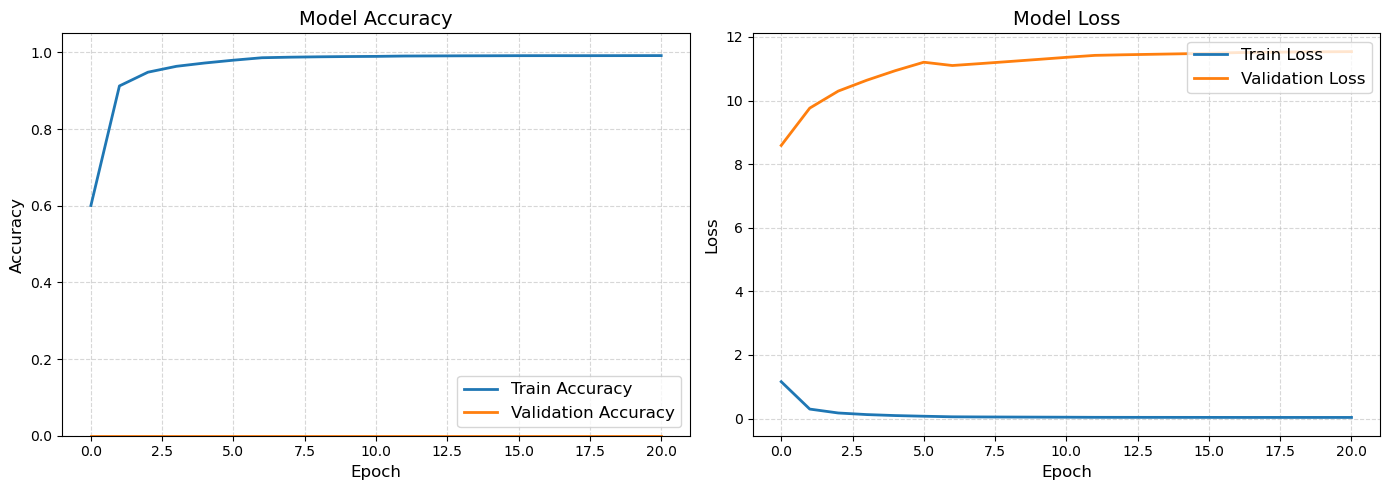

In [91]:
# %%
# Improved plotting function
def plot_training_history(history):
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylim([0, 1.05])  # Set consistent y-axis limits
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [93]:
from tensorflow.keras.initializers import HeNormal
#trying with relu instead of sigmoid
model = Sequential([
    Dense(128, activation='relu', input_shape=(784,), kernel_initializer=HeNormal()),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(10, activation='softmax')
])

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8024 - loss: 0.6187 - val_accuracy: 0.0000e+00 - val_loss: 15.2636 - learning_rate: 0.0010
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9619 - loss: 0.1187 - val_accuracy: 0.0000e+00 - val_loss: 15.1193 - learning_rate: 0.0010
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9824 - loss: 0.0625 - val_accuracy: 0.0000e+00 - val_loss: 16.5828 - learning_rate: 0.0010
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9892 - loss: 0.0392 - val_accuracy: 0.0000e+00 - val_loss: 17.8327 - learning_rate: 0.0010
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9925 - loss: 0.0280 - val_accuracy: 0.0000e+00 - val_loss: 19.0574 - learning_rate: 0.0010
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9941 - loss: 0.0195 - val_accuracy: 0.0000e+00 - val_loss: 18.3346 - learning_rate: 0.0010
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accu

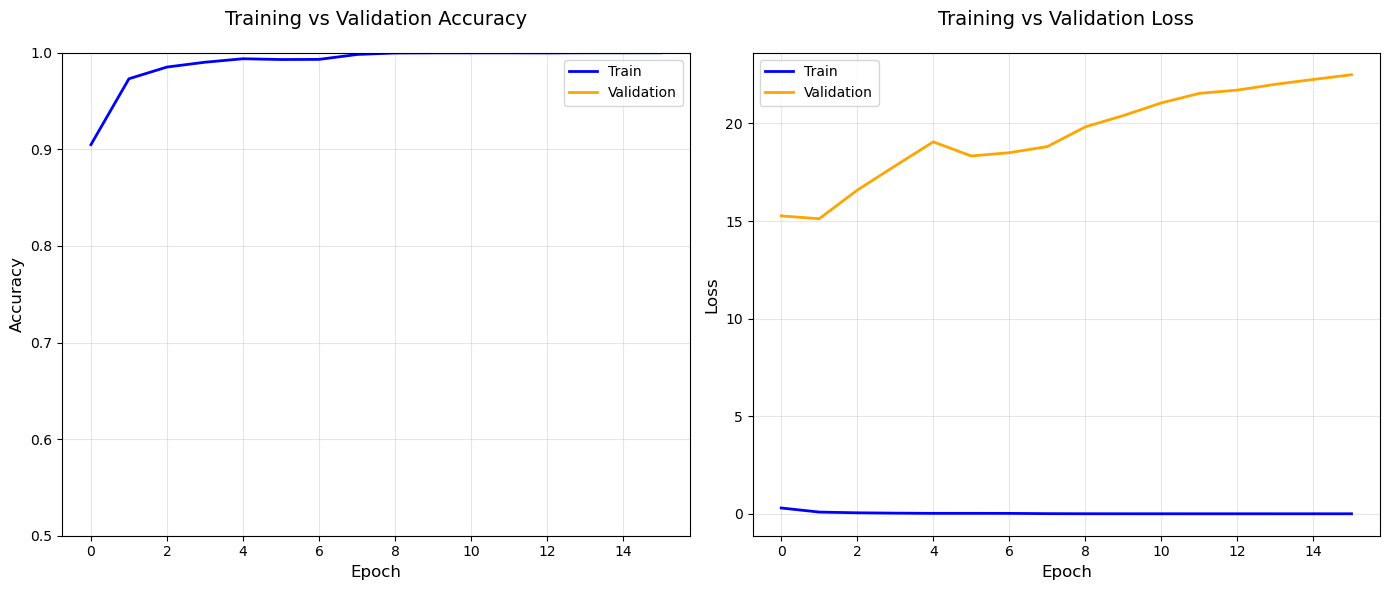

In [95]:
# Improved training configuration
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Better optimizer configuration
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

# 2. Improved callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, min_delta=0.005),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# 3. Compile with improved settings
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Train with validation split
history = model.fit(
    X_train, y_train_cat,
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# 5. Enhanced visualization
def plot_improved_curves(history):
    plt.figure(figsize=(14, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train', linewidth=2, color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='orange')
    plt.title('Training vs Validation Accuracy', fontsize=14, pad=20)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylim([0.5, 1.0])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train', linewidth=2, color='blue')
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2, color='orange')
    plt.title('Training vs Validation Loss', fontsize=14, pad=20)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_improved_curves(history)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,042 (953.29 KB)

 Trainable params: 243,402 (950.79 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7060 - loss: 0.9456 - val_accuracy: 0.0000e+00 - val_loss: 4.1024 - learning_rate: 5.0000e-04
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9470 - loss: 0.1922 - val_accuracy: 0.0000e+00 - val_loss: 5.3457 - learning_rate: 5.0000e-04
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9714 - loss: 0.1094 - val_accuracy: 0.0000e+00 - val_loss: 5.8990 - learning_rate: 5.0000e-04
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9835 - loss: 0.0691 - val_accuracy: 0.0000e+00 - val_loss: 6.2542 - learning_rate: 5.0000e-04
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9900 - loss: 0.0442 - val_accuracy: 0.0000e+00 - val_loss: 6.4845 - learning_rate: 2.5000e-04
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9924 - loss: 0.0334 - val_accuracy: 0.0000e+00 - val_loss: 6.7344 - learning_rate: 2.5000e-04
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━

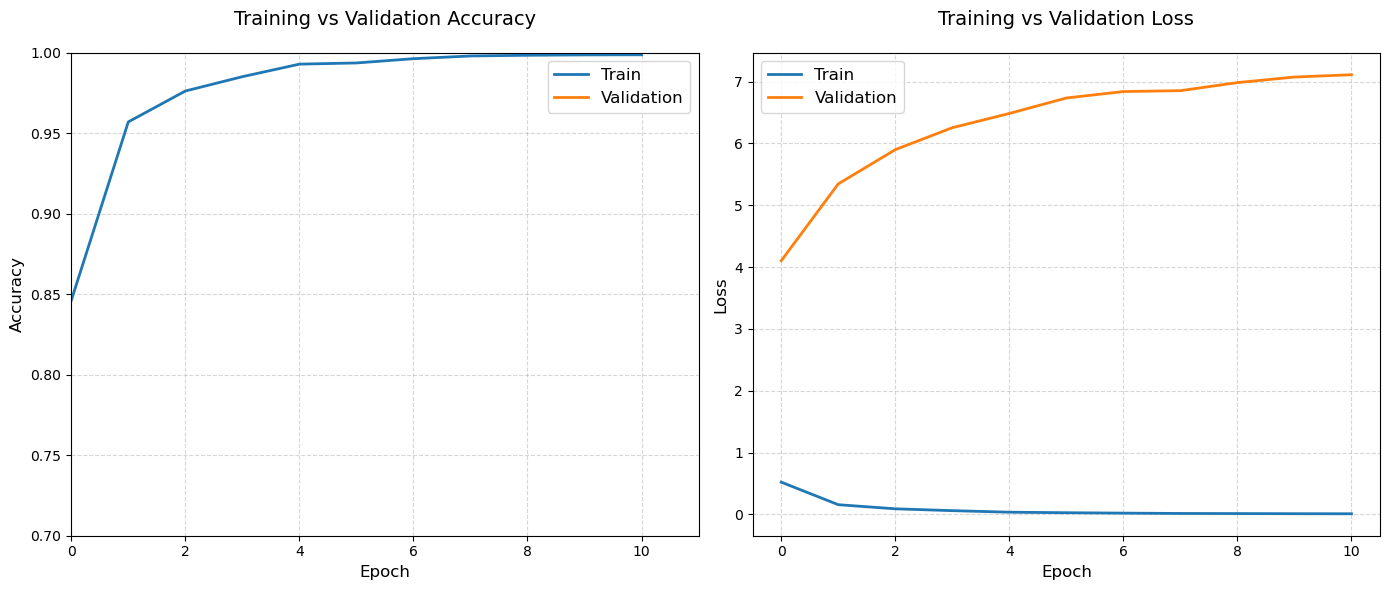


Final Test Accuracy: 0.7530
Final Test Loss: 1.0325
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       300
           1       0.76      0.98      0.86       300
           2       0.85      0.77      0.80       300
           3       0.60      0.98      0.75       300
           4       0.71      0.96      0.81       300
           5       0.90      0.94      0.92       300
           6       0.88      0.93      0.90       300
           7       0.79      0.98      0.88       300
           8       0.00      0.00      0.00       300
           9       0.00      0.00      0.00       300

    accuracy                           0.75      3000
   macro avg       0.62      0.75      0.67      3000
weighted avg       0.62      0.75      0.67      3000



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [97]:
# Corrected Implementation with ReLU

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


# 1. Enhanced Model Architecture

def create_enhanced_model():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(784,), kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        Dense(128, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(0.3),
        Dense(64, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.BatchNormalization(),
        Dense(10, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_enhanced_model()
model.summary()


callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, 
                 restore_best_weights=True, min_delta=0.001),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                     patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train_cat,
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)


def plot_enhanced_curves(history):
    plt.figure(figsize=(14, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train', linewidth=2, color='#1f77b4')
    plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='#ff7f0e')
    plt.title('Training vs Validation Accuracy', fontsize=14, pad=20)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylim([0.7, 1.0])
    plt.xlim([0, len(history.history['accuracy'])])
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train', linewidth=2, color='#1f77b4')
    plt.plot(history.history['val_loss'], label='Validation', linewidth=2, color='#ff7f0e')
    plt.title('Training vs Validation Loss', fontsize=14, pad=20)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

plot_enhanced_curves(history)


# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [101]:
# Task 5: Evaluate the Model

test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.7530
Test Loss: 1.0325



Loaded Model Test Accuracy: 0.7530
Loaded Model Test Loss: 1.0325
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


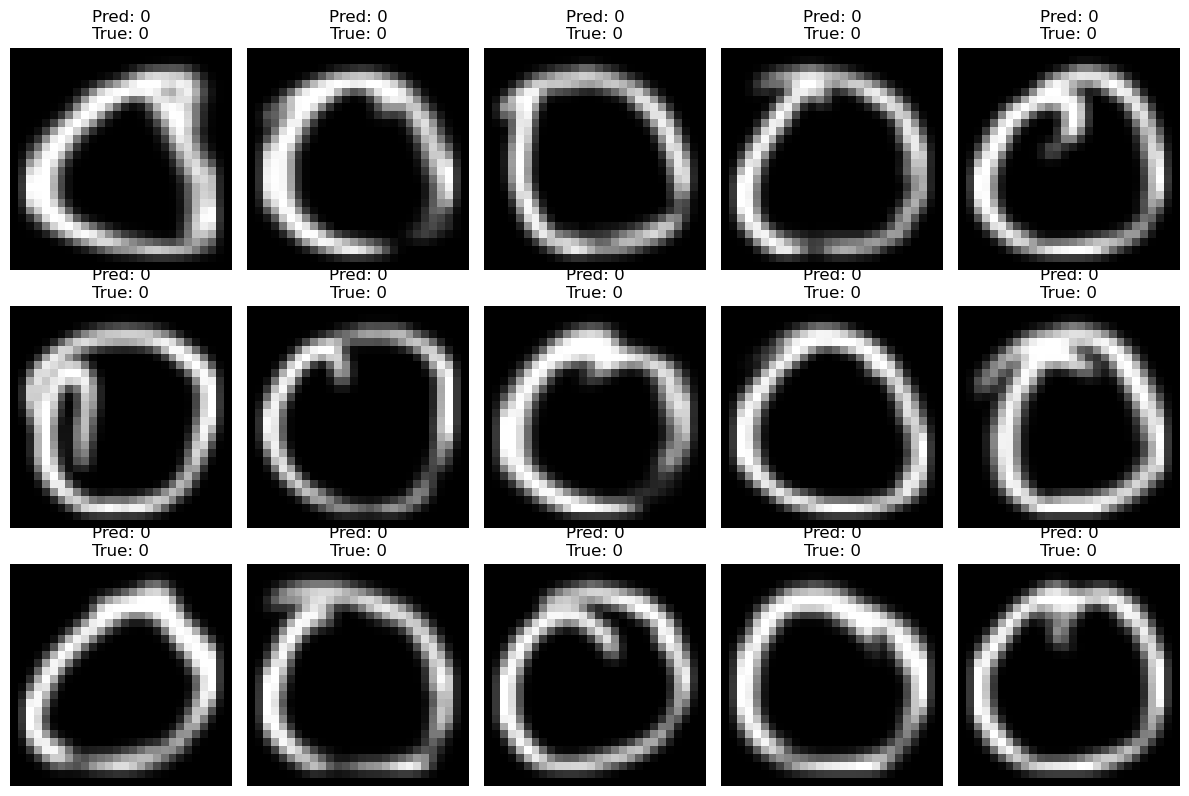

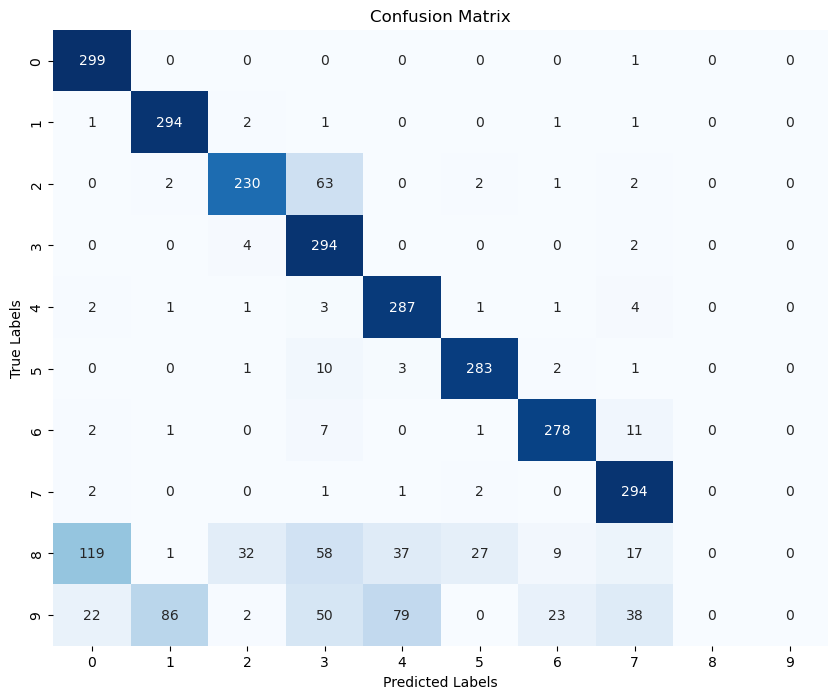

In [105]:

# Save model
model.save('devanagari_digit_fcn.h5')

# Load model demonstration
from tensorflow.keras.models import load_model
loaded_model = load_model('devanagari_digit_fcn.h5')
loaded_loss, loaded_acc = loaded_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nLoaded Model Test Accuracy: {loaded_acc:.4f}")
print(f"Loaded Model Test Loss: {loaded_loss:.4f}")


# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Display predictions
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
